In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import pandas as pd
from pandas.plotting import scatter_matrix
import tensorflow_probability as tfp
from tensorflow.keras import layers

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
def make_disc_model(nn_list):
    model = tf.keras.Sequential()
    model.add(layers.Dense(nn_list[0]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[2]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1,activation='sigmoid'))
    
    return model

def make_gen_model(nn_list,output_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(nn_list[0]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[2]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(output_dim))

    return model

class T_gen(tf.keras.Model):
    
    def __init__(self,n,m,K_nn_list,F_nn_list):
        super(T_gen,self).__init__(name='T')
        self.n = n # dimensionality of observable
        self.m = m # dimensionality of parameter
        self.dim = n+m
        self.K = make_gen_model(K_nn_list,n)
        self.F = make_gen_model(F_nn_list,m)
        
    def call(self, inputs):
        x = inputs[...,:self.n]
        y = inputs[...,self.n:]
        T1 = self.K(x)
        T2 = self.F(tf.concat([T1,y],axis=-1))
        
        return tf.concat([T1,T2],axis = -1)
    
    def sample(self,N):
        perm = tfb.Permute(list(range(self.n,self.dim))+list(range(self.n)))
        return perm.forward(self.call(tf.random.normal([N,self.dim]))).numpy()
    
    def conditional_sample(self,x_obs,N):
        u = tf.random.normal([N,self.m])
        x_obs = tf.reshape(x_obs,[1,-1])
        x_obs_batch = tf.tile(x_obs,tf.constant([N,1]))
        return self.F(tf.concat([x_obs_batch,u],axis=-1)).numpy()

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
file = h5py.File('BeamSamples.h5','r')
joint_samples_y_x = np.array(file['Samples/'],dtype=np.float32)
n = 6 # dimensionality of observable
m = 3 # dimensionality of parameter
latent_dim = n+m
x = joint_samples_y_x[:,m:]
y = joint_samples_y_x[:,:m]
# columns in X,Y format for y~p(y|x)
joint_samples = np.concatenate([x,y],axis=-1)
scaler = MinMaxScaler()
scaled_samples = scaler.fit_transform(joint_samples)
NUM_SAMPLES = joint_samples.shape[0]
BATCH_SIZE = 200
dataset = tf.data.Dataset.from_tensor_slices(scaled_samples)
dataset = dataset.shuffle(buffer_size=NUM_SAMPLES).batch(BATCH_SIZE)

lr = 1e-4
lamda = 0.01 # monoticity lagrange multiplier 
disc_nn_list = [200,500,100]
K_nn_list = [200,500,100]
F_nn_list = [200,500,100]
N_epochs = 100

f = make_disc_model(disc_nn_list)
T = T_gen(n,m,K_nn_list,F_nn_list)

gen_opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)
disc_opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

def gen_loss():
    z1 = tf.random.normal([BATCH_SIZE,latent_dim])
    z2 = tf.random.normal([BATCH_SIZE,latent_dim])
    T1 = T(z1)
    T2 = T(z2)
    g_loss_fake = tf.reduce_mean(tf.math.log(f(T1)),axis=0)
    m_loss = lamda*tf.reduce_mean(tf.reduce_sum((T1-T2)*(z1-z2),axis=1))
    g_loss = g_loss_fake + m_loss
    return -g_loss

def disc_loss(x):
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    d_loss_real = tf.reduce_mean(tf.math.log(f(x)),axis=0)
    d_loss_fake = tf.reduce_mean(tf.math.log(1.0-f(T(z))),axis=0)
    d_loss = d_loss_real+d_loss_fake
    return -d_loss 
    

# input x is minibatch of data points
@tf.function
def train_step(x): 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        g_loss = gen_loss()
        d_loss = disc_loss(x)
        
    gen_grad = gen_tape.gradient(g_loss, T.trainable_variables)
    disc_grad = disc_tape.gradient(d_loss, f.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad,T.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad,f.trainable_variables))
    
    return d_loss,g_loss
      
def train(dataset, epochs):
    for epoch in range(epochs):
        for data_batch in dataset:
            d_loss,g_loss = train_step(data_batch)
        if epoch % 10 == 0: 
            print('it:',epoch,"D loss:",d_loss.numpy(),"G loss:",g_loss.numpy())
            
train(dataset,N_epochs)

it: 0 D loss: [1.2221996] G loss: [0.7741312]
it: 10 D loss: [1.4689683] G loss: [0.6715457]
it: 20 D loss: [1.3104002] G loss: [0.71419495]
it: 30 D loss: [1.4039485] G loss: [0.6938301]
it: 40 D loss: [1.3168511] G loss: [0.7941899]


KeyboardInterrupt: 

<Figure size 3600x3600 with 0 Axes>

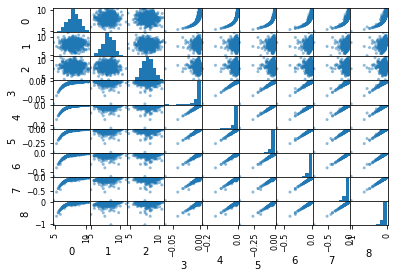

<Figure size 3600x3600 with 0 Axes>

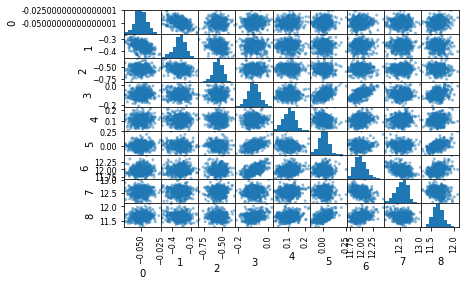

In [6]:
plt.figure(figsize=(50,50))
scatter_matrix(pd.DataFrame(joint_samples_y_x[::100,:]))
plt.show()

fig = plt.figure(figsize=(50,50))
X = scaler.inverse_transform(T.sample(500))
scatter_matrix(pd.DataFrame(X))
plt.savefig('images/MGAN-Scatter-Matrix.png')
plt.show()

In [ ]:
test_values = np.array(file['TestValues'],dtype=np.float32)
m_x_scaled = scaler.transform(np.reshape(test_values,(1,-1)))
x_obs = m_x_scaled[0,m:]

# unscaling sampled parameters (m1,m2,m3)
data_min = scaler.data_min_[:m]
data_max = scaler.data_max_[:m]
scale = scaler.scale_[:m]
N = 2000
samples_unscaled = T.conditional_sample(x_obs,N)*(data_max-data_min) + data_min

fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(test_values[:m])

axs[0].hist(samples_unscaled[:,0],50,density=True)
axs[0].axvline(m1,ymax=0.95,c='r',ls='--',lw=2.0,label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()

axs[1].hist(samples_unscaled[:,1],50,density=True)
axs[1].axvline(m2,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()

axs[2].hist(samples_unscaled[:,2],50,density=True)
axs[2].axvline(m3,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()

plt.subplots_adjust(top=0.85)

plt.savefig('images/MGAN-Euler_Beam.png')